In [3]:
import pandas as pd


df = pd.read_csv("../data/processed/processed.csv") #read the dataset

sub = df[["Flight Distance", "satisfaction"]].copy() #select relevant columns

# change satisfaction to numerical values
mapping = {
    "satisfied": 1, # 1 for satisfied
    "neutral or dissatisfied": 0 # 0 for neutral or dissatisfied
}
sub["satisfaction_num"] = sub["satisfaction"].map(mapping) # map satisfaction to numerical values

print(sub.head()) # print the first few rows of the new dataframe
print(sub["satisfaction_num"].value_counts()) #print the counts of each satisfaction level


   Flight Distance             satisfaction  satisfaction_num
0              160                satisfied                 1
1             2863                satisfied                 1
2              192  neutral or dissatisfied                 0
3             3377                satisfied                 1
4             1182                satisfied                 1
satisfaction_num
0    14573
1    11403
Name: count, dtype: int64


In [ ]:
# Group by satisfaction_num and calculate descriptive statistics for flight distance
stats_by_class = sub.groupby("satisfaction_num")["Flight Distance"].agg(
    ["count", "mean", "median", "std"] 
).round(2) # calculate count, mean, median, and standard deviation

print(stats_by_class)


                  count     mean  median      std
satisfaction_num                                 
0                 14573   932.93   679.0   794.70
1                 11403  1527.17  1237.0  1125.55


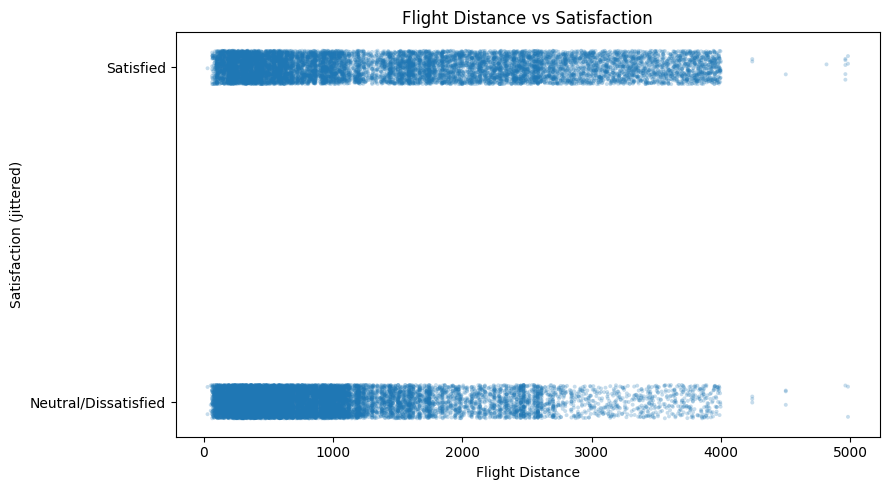

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create jitter for y-axis to avoid overlapping points
rng = np.random.default_rng(42)  # random number generator (fixed seed for reproducibility)
y_jitter = rng.uniform(-0.05, 0.05, size=len(sub))

plt.figure(figsize=(9, 5))
plt.scatter(
    sub["Flight Distance"],                 # x-axis: flight distance
    sub["satisfaction_num"] + y_jitter,     # y-axis: satisfaction with jitter
    s=8,                                    # point size
    alpha=0.25,                             # transparency
    edgecolors="none"                       # cleaner look
)

# Customize axis labels and title
plt.yticks([0, 1], ["Neutral/Dissatisfied", "Satisfied"])
plt.xlabel("Flight Distance")
plt.ylabel("Satisfaction (jittered)")
plt.title("Flight Distance vs Satisfaction")

plt.tight_layout()
plt.show()


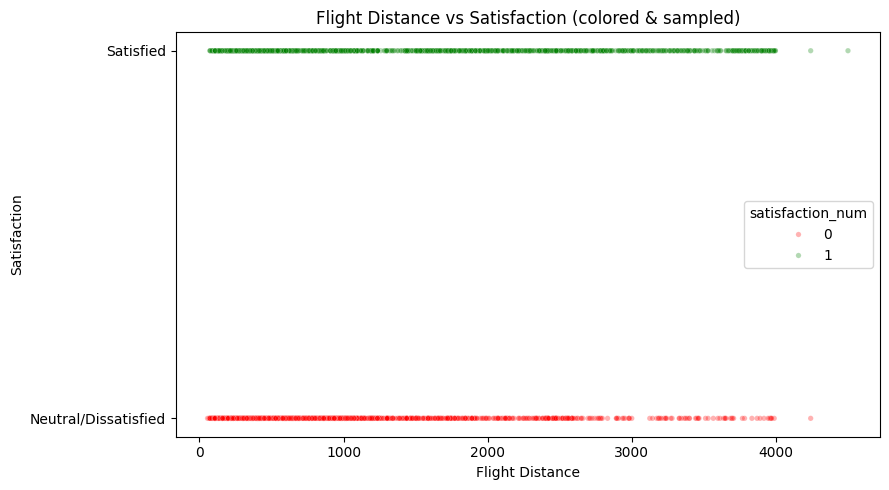

In [6]:
import seaborn as sns

plt.figure(figsize=(9, 5))

# Use seaborn scatterplot with hue (color by satisfaction_num)
sns.scatterplot(
    data=sub.sample(3000, random_state=42),  # sample 3k points to avoid overplotting
    x="Flight Distance",
    y="satisfaction_num",
    hue="satisfaction_num",
    alpha=0.3,
    palette={0: "red", 1: "green"},
    s=15
)

plt.yticks([0, 1], ["Neutral/Dissatisfied", "Satisfied"])
plt.xlabel("Flight Distance")
plt.ylabel("Satisfaction")
plt.title("Flight Distance vs Satisfaction (colored & sampled)")

plt.tight_layout()
plt.show()


Medians (should be ~679 for Neutral/Dissatisfied and ~1237 for Satisfied):
satisfaction_label
Neutral/Dissatisfied     679.0
Satisfied               1237.0
Name: Flight Distance, dtype: float64


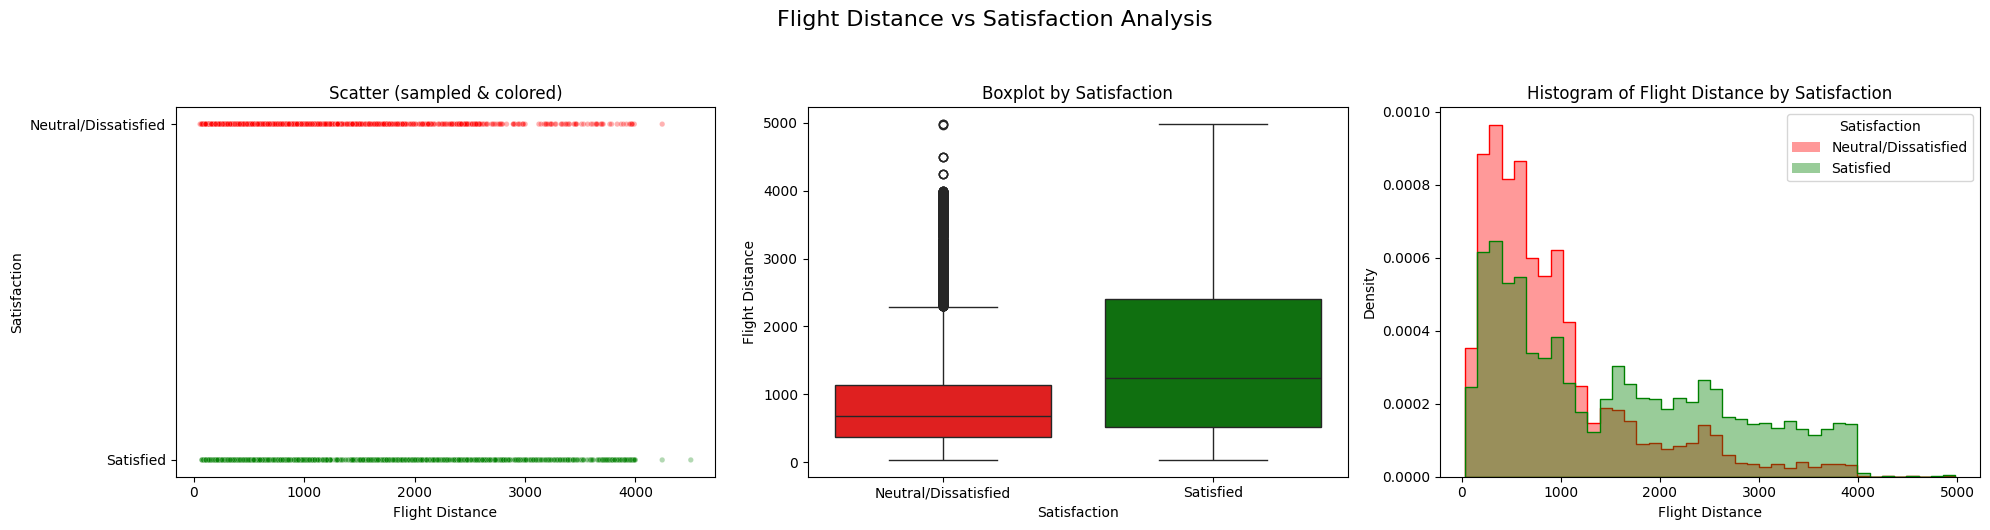

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# --- Labels & order (single source of truth)
label_map = {0: "Neutral/Dissatisfied", 1: "Satisfied"}
sub["satisfaction_label"] = sub["satisfaction_num"].map(label_map)

order = ["Neutral/Dissatisfied", "Satisfied"]
sub["satisfaction_label"] = pd.Categorical(
    sub["satisfaction_label"], categories=order, ordered=True
)

palette = {"Neutral/Dissatisfied": "red", "Satisfied": "green"}

# --- Quick sanity check (should match earlier table)
check = sub.groupby("satisfaction_label", observed=False)["Flight Distance"].median()
print("Medians (should be ~679 for Neutral/Dissatisfied and ~1237 for Satisfied):")
print(check)

# --- Figure with 3 panels
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1) Scatter (sampled to reduce overplotting)
sns.scatterplot(
    data=sub.sample(3000, random_state=42),
    x="Flight Distance",
    y="satisfaction_label",
    hue="satisfaction_label",
    hue_order=order,
    palette=palette,
    alpha=0.3,
    s=15,
    ax=axes[0],
    legend=False
)
axes[0].set_title("Scatter (sampled & colored)")
axes[0].set_ylabel("Satisfaction")

# 2) Boxplot (future-safe: explicit hue, no duplicate legend)
sns.boxplot(
    data=sub,
    x="satisfaction_label",
    y="Flight Distance",
    hue="satisfaction_label",
    hue_order=order,
    dodge=False,
    legend=False,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Boxplot by Satisfaction")
axes[1].set_xlabel("Satisfaction")

# 3) Histogram — draw each group separately with fixed colors (no seaborn hue)
axes[2].set_title("Histogram of Flight Distance by Satisfaction")
axes[2].set_xlabel("Flight Distance")
axes[2].set_ylabel("Density")

# Shared bin edges so both groups use identical bins
bin_edges = np.histogram_bin_edges(sub["Flight Distance"], bins=40)

# Plot Neutral/Dissatisfied in red
sns.histplot(
    data=sub[sub["satisfaction_label"] == "Neutral/Dissatisfied"],
    x="Flight Distance",
    bins=bin_edges,
    stat="density",
    element="step",
    alpha=0.4,
    color=palette["Neutral/Dissatisfied"],
    ax=axes[2]
)

# Plot Satisfied in green
sns.histplot(
    data=sub[sub["satisfaction_label"] == "Satisfied"],
    x="Flight Distance",
    bins=bin_edges,
    stat="density",
    element="step",
    alpha=0.4,
    color=palette["Satisfied"],
    ax=axes[2]
)

# Manual legend (guaranteed correct colors)
custom_legend = [
    Patch(facecolor=palette["Neutral/Dissatisfied"], alpha=0.4, label="Neutral/Dissatisfied"),
    Patch(facecolor=palette["Satisfied"], alpha=0.4, label="Satisfied")
]
axes[2].legend(handles=custom_legend, title="Satisfaction")

# Global title & layout
plt.suptitle("Flight Distance vs Satisfaction Analysis", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [17]:
from pathlib import Path

# Paths for saving
fig_path = Path("../reports/figures/flight_distance_satisfaction.png")
tbl_path = Path("../reports/tables/flight_distance_satisfaction_stats.csv")

# Ensure directories exist
fig_path.parent.mkdir(parents=True, exist_ok=True)
tbl_path.parent.mkdir(parents=True, exist_ok=True)

# 1) Save the figure (the last one we created with 3 subplots)
fig.savefig(fig_path, dpi=300)

# 2) Save the summary stats table
stats_by_class = sub.groupby("satisfaction_label")["Flight Distance"].agg(
    ["count", "mean", "median", "std"]
).round(2)
stats_by_class.to_csv(tbl_path)

print("Figure saved to:", fig_path)
print("Table saved to:", tbl_path)


Figure saved to: ..\reports\figures\flight_distance_satisfaction.png
Table saved to: ..\reports\tables\flight_distance_satisfaction_stats.csv


C:\Users\alikm\AppData\Local\Temp\ipykernel_16864\195880370.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_by_class = sub.groupby("satisfaction_label")["Flight Distance"].agg(
